[View in Colaboratory](https://colab.research.google.com/github/fuulish/colab/blob/master/accumulation_test.ipynb)

Install necessary components

In [16]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple


general preparations

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torch.nn import init

import itertools

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
dtype = torch.float64

create general model

In [18]:
class Net(torch.nn.Module):
    def __init__(self, D_in, H, D_out, bias=None):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(D_in, H)
        self.fc2 = torch.nn.Linear(H, H)
        self.fc3 = torch.nn.Linear(H, D_out)

        init.xavier_uniform_(self.fc1.weight, gain=np.sqrt(2))
        init.xavier_uniform_(self.fc2.weight, gain=np.sqrt(2))
        init.xavier_uniform_(self.fc3.weight, gain=np.sqrt(2))

        if bias is not None:
            init.constant(self.fc3.bias, bias)
            self.fc3.bias.requires_grad = False

        # self.activation = torch.nn.ReLU()
        self.activation = torch.nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)

        return x

prep data

In [19]:
natom = 10
npoint = 10000

x1 = np.random.rand(natom, npoint, 1)
x2 = np.random.rand(natom, npoint, 1)

y = np.sum(np.exp(-x1) + np.sin(x2), axis=0)

# x1 = 2.*(x1 - np.min(x1))/(np.max(x1)-np.min(x1)) - 1
# x2 = 2.*(x2 - np.min(x2))/(np.max(x2)-np.min(x2)) - 1

# x1 = (x1 - x1.mean()) / x1.std()
# x2 = (x2 - x2.mean()) / x2.std()

x1 = torch.tensor(x1, dtype=dtype, device=device)
x2 = torch.tensor(x2, dtype=dtype, device=device)

y = torch.tensor(y, dtype=dtype, device=device)

setup models

In [20]:
models = []
for x in [x1, x2]:
    model = Net(1, 10, 1) #, bias=x.mean())
    model = model.double().to(device)
    models.append(model)

setup optimizers

In [21]:
parmchain = itertools.chain()

for model in models:
    parmchain = itertools.chain(parmchain, model.parameters())

base_learning_rate = learning_rate = 1.e-1
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, parmchain), lr=learning_rate)
# optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, parmchain), lr=learning_rate)

lambda1 = lambda epoch: 0.999**epoch
lambda1 = lambda epoch: 1.
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

loss_func = torch.nn.MSELoss(size_average=True)

nepoch = 1000

def evaluate(models, features):
    y_pred = 0.
    for model, x in zip(models, features):
        y_pred += torch.sum(model(x), dim=0)

    return y_pred

optimize model

In [22]:
for t in range(nepoch):
    y_pred = evaluate(models, [x1, x2])

    optimizer.zero_grad()
    loss = loss_func(y_pred, y)
    loss.backward()

    optimizer.step()
    scheduler.step()

    if t % 10 == 0:
        print(t, loss.item())

0 475.301937894752
10 68.77245734081971
20 1.6654588198060418
30 12.355513257625377
40 0.1695878360672125
50 1.6004564039962415
60 0.32393834672728444
70 0.05873691744293361
80 0.0775930408316066
90 0.044262361702132304
100 0.022427105645593373
110 0.01459346651893905
120 0.012085898166036798
130 0.011088155522188406
140 0.01048935665528815
150 0.010051185293585636
160 0.00971296086015541
170 0.009426555934279282
180 0.009157783073674123
190 0.008897573359825564
200 0.008648230985340339
210 0.008409119329344832
220 0.008178517146373616
230 0.007955893928382906
240 0.007740492790113801
250 0.007531652875321759
260 0.007328804504546025
270 0.007131437017642965
280 0.0069391130148159785
290 0.006751460693430693
300 0.006568169646015852
310 0.006388985439002007
320 0.006213703290394144
330 0.006042162050578781
340 0.005874238144358528
350 0.005709839815793145
360 0.005548901752607304
370 0.005391380170391616
380 0.005237248390869189
390 0.005086492912244057
400 0.0049391099671984694
410 0.

plot results

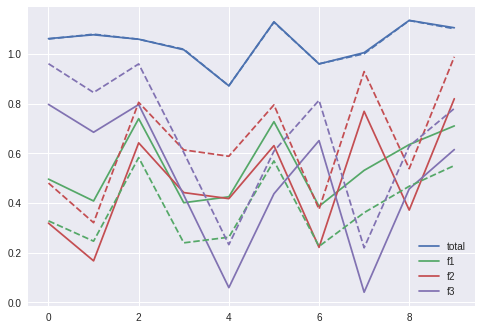

In [23]:
stride = 1000

p1 = plt.plot(y.data.cpu().numpy()[::stride] / natom, label='total')
p2 = plt.plot(np.exp(-x1[0].data.cpu().numpy().sum(axis=1))[::stride], label='f1')
p3 = plt.plot(np.sin(x2[0].data.cpu().numpy().sum(axis=1))[::stride], label='f2')
p4 = plt.plot(np.sin(x2[1].data.cpu().numpy().sum(axis=1))[::stride], label='f3')

plt.plot(evaluate(models, [x1,x2]).data.cpu().numpy()[::stride] / natom, '--', color=p1[0].get_color())
plt.plot(models[0](x1[0]).data.cpu().numpy().sum(axis=1)[::stride], '--', color=p2[0].get_color())
plt.plot(models[1](x2[0]).data.cpu().numpy().sum(axis=1)[::stride], '--', color=p3[0].get_color())
plt.plot(models[1](x2[1]).data.cpu().numpy().sum(axis=1)[::stride], '--', color=p4[0].get_color())

plt.legend()

plt.show()